<a href="https://colab.research.google.com/github/AkarshKollana/DBT_bq_demo/blob/dbt_new_branch/case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install statsmodels scikit-learn scipy


In [ ]:
#@title Imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, chisquare
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

SELECT
date, campaign_id, advertiser_id, geo, device, app_category,
impressions, clicks, conversions, spend, revenue,
bidder_version, bounce_rate_proxy
from analytics.campaign_daily_metrics
WHERE date BETWEEN :start and :end;

In [ ]:
#@title Data generator (run once)
DATA_PATH = "ads_case_study_data.csv"

def generate_synthetic_ads_data(path: str, n_campaigns: int = 700, n_days: int = 70):
    days = pd.date_range("2025-01-01", periods=n_days, freq="D")
    rollout_day = days[int(n_days/2)]

    geos = ["US", "KR", "JP", "IN", "BR", "DE"]
    devices = ["ios", "android", "web"]
    cats = ["games", "shopping", "finance", "social", "video"]

    rows = []
    for campaign_id in range(1, n_campaigns + 1):
        advertiser_id = np.random.randint(1, int(n_campaigns/3) + 1)
        geo = np.random.choice(geos, p=[0.45, 0.08, 0.08, 0.15, 0.12, 0.12])
        device = np.random.choice(devices, p=[0.38, 0.45, 0.17])
        cat = np.random.choice(cats, p=[0.35, 0.2, 0.1, 0.2, 0.15])

        # latent campaign quality (confounder)
        quality = np.clip(np.random.beta(2.0, 3.0), 0, 1)

        # baseline scale of impressions (skewed)
        base_impr = int(np.random.lognormal(mean=8.2 + 0.8*quality, sigma=0.55))

        geo_ctr_adj = {"US": 0.0000, "KR": 0.0010, "JP": 0.0006, "IN": -0.0002, "BR": -0.0006, "DE": 0.0002}[geo]
        dev_ctr_adj = {"ios": 0.0004, "android": 0.0002, "web": -0.0003}[device]
        cat_ctr_adj = {"games": 0.0005, "shopping": 0.0001, "finance": -0.0002, "social": 0.0003, "video": 0.0000}[cat]

        base_ctr = 0.007 + 0.02*quality + geo_ctr_adj + dev_ctr_adj + cat_ctr_adj
        base_ctr = float(np.clip(base_ctr, 0.001, 0.12))

        base_cvr = 0.03 + 0.18*quality + (0.01 if cat in ["shopping", "finance"] else 0.0)
        base_cvr = float(np.clip(base_cvr, 0.001, 0.6))

        value = float(np.random.lognormal(mean=3.2 + 0.9*quality + (0.3 if cat=="finance" else 0.0), sigma=0.35))
        base_cpc = 0.6 + 1.4*quality + (0.15 if device=="ios" else 0.0) + (0.25 if cat=="finance" else 0.0)

        for d in days:
            post = int(d >= rollout_day)

            impr = max(50, int(base_impr * np.random.lognormal(mean=0, sigma=0.18)))

            # selection bias: high-quality campaigns more likely to be treated post-rollout
            p_treat = 0.05 + 0.75*(1/(1+np.exp(-(-1.0 + 4.0*quality))))
            treat = int((np.random.rand() < p_treat) and post == 1)

            # true effect: CTR improves; CPC up; CVR slightly down (tradeoff)
            ctr = base_ctr + (0.0012 if treat==1 else 0.0) + (0.0004*post)
            cvr = base_cvr - (0.012 if treat==1 else 0.0)
            cpc = base_cpc + (0.18 if treat==1 else 0.0)

            ctr = float(np.clip(ctr, 0.0005, 0.20))
            cvr = float(np.clip(cvr, 0.0001, 0.9))

            clicks = np.random.binomial(impr, ctr)
            convs = np.random.binomial(clicks, cvr) if clicks > 0 else 0
            revenue = convs * value
            spend = clicks * cpc

            bounce = float(np.clip(0.35 - 0.12*quality + (0.04 if treat==1 else 0.0) + np.random.normal(0, 0.03), 0.05, 0.95))

            rows.append({
                "date": d,
                "campaign_id": campaign_id,
                "advertiser_id": advertiser_id,
                "geo": geo,
                "device": device,
                "app_category": cat,
                "quality": quality,
                "post": post,
                "treat": treat,
                "impressions": impr,
                "clicks": clicks,
                "conversions": convs,
                "spend": spend,
                "revenue": revenue,
                "cpc": cpc,
                "value_per_conv": value,
                "bounce_rate_proxy": bounce
            })

    df = pd.DataFrame(rows)

    # Inject data issues
    m_idx = np.random.choice(df.index, size=int(0.002*len(df)), replace=False)
    df.loc[m_idx, "bounce_rate_proxy"] = np.nan

    dup_idx = np.random.choice(df.index, size=int(0.0015*len(df)), replace=False)
    df = pd.concat([df, df.loc[dup_idx]], ignore_index=True)

    bad_idx = np.random.choice(df.index, size=int(0.0005*len(df)), replace=False)
    df.loc[bad_idx, "spend"] = -abs(df.loc[bad_idx, "spend"])

    df.to_csv(path, index=False)
    return df

# LOADING THE DATA (Generate if missing)

In [ ]:
if not os.path.exists(DATA_PATH):
  df = generate_synthetic_ads_data(DATA_PATH)

else:
  df = pd.read_csv(DATA_PATH, parse_dates=['date'])

df.head()

,date,campaign_id,advertiser_id,geo,device,app_category,quality,post,treat,impressions,clicks,conversions,spend,revenue,cpc,value_per_conv,bounce_rate_proxy
0,2025-01-01,1,103,BR,ios,social,0.064885,0,0,2159,25,0,21.020986,0.000000,0.840839,22.513853,0.347139
1,2025-01-02,1,103,BR,ios,social,0.064885,0,0,2365,13,2,10.930913,45.027706,0.840839,22.513853,0.329380
2,2025-01-03,1,103,BR,ios,social,0.064885,0,0,2251,17,3,14.294270,67.541559,0.840839,22.513853,0.337298
3,2025-01-04,1,103,BR,ios,social,0.064885,0,0,2889,23,0,19.339307,0.000000,0.840839,22.513853,0.339071
4,2025-01-05,1,103,BR,ios,social,0.064885,0,0,2396,11,0,9.249234,0.000000,0.840839,22.513853,0.362153


# 2) Data Validation and cleaning
### Duplicates at the correct grain
### missingness
### impossible values
### metric sanity
### keep raw, create cleaned copy

# Data QA Checks


In [ ]:
#@title Data QA checks
print("Rows:", len(df))
print("Duplicate campaign-day rows:", df.duplicated(subset=["date","campaign_id"]).sum())

missing = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (top):")
print(missing.head(10))

bad_spend = (df["spend"] < 0).sum()
bad_clicks = (df["clicks"] > df["impressions"]).sum()
print("\nBad rows:", {"spend<0": int(bad_spend), "clicks>impr": int(bad_clicks)})

Rows: 49073
Duplicate campaign-day rows: 73

Missingness (top):
bounce_rate_proxy    0.001997
date                 0.000000
campaign_id          0.000000
geo                  0.000000
advertiser_id        0.000000
app_category         0.000000
quality              0.000000
post                 0.000000
device               0.000000
treat                0.000000
dtype: float64

Bad rows: {'spend<0': 24, 'clicks>impr': 0}


In [ ]:
#@title Clean dataset + derived metrics (Exact Case Study Version)
df_clean = df.copy()

# 1. Deduplication and Sorting (String-based sorting as per Case Study)
df_clean = df_clean.sort_values(["date","campaign_id"]).drop_duplicates(subset=["date","campaign_id"], keep="first")
df_clean = df_clean[df_clean["spend"] >= 0].copy()

# 2. Impute Bounce Rate
df_clean["bounce_rate_proxy"] = df_clean["bounce_rate_proxy"].fillna(df_clean["bounce_rate_proxy"].median())

# 3. Metrics (Using exact Case Study formulas with np.nan)
# Note: np.nan will make ROAS and CPA look "unpopulated" where spend/conv are 0.
df_clean["ctr"] = df_clean["clicks"] / df_clean["impressions"]
df_clean["cvr"] = np.where(df_clean["clicks"] > 0, df_clean["conversions"] / df_clean["clicks"], 0.0)
df_clean["roas"] = np.where(df_clean["spend"] > 0, df_clean["revenue"] / df_clean["spend"], np.nan)
df_clean["cpa"] = np.where(df_clean["conversions"] > 0, df_clean["spend"] / df_clean["conversions"], np.nan)

# 4. Display the first 30 rows of the data
df_clean.head(30)

,date,campaign_id,advertiser_id,geo,device,app_category,quality,post,treat,impressions,clicks,conversions,spend,revenue,cpc,value_per_conv,bounce_rate_proxy,ctr,cvr,roas,cpa
0,2025-01-01,1,103,BR,ios,social,0.064885,0,0,2159,25,0,21.020986,0.000000,0.840839,22.513853,0.347139,0.011579,0.000000,0.000000,NaN
70,2025-01-01,2,12,US,android,social,0.595948,0,0,7132,148,18,212.280473,721.386529,1.434328,40.077029,0.296341,0.020752,0.121622,3.398271,11.793360
140,2025-01-01,3,78,JP,android,video,0.170070,0,0,7793,80,7,67.047850,235.649875,0.838098,33.664268,0.358339,0.010266,0.087500,3.514652,9.578264
210,2025-01-01,4,59,US,android,games,0.347732,0,0,1294,17,2,18.476021,187.601390,1.086825,93.800695,0.320374,0.013138,0.117647,10.153777,9.238010
280,2025-01-01,5,95,KR,android,games,0.211876,0,0,2472,29,6,26.002155,156.538945,0.896626,26.089824,0.319583,0.011731,0.206897,6.020230,4.333692
350,2025-01-01,6,168,US,android,video,0.322854,0,0,4493,68,3,71.535716,79.361275,1.051996,26.453758,0.321542,0.015135,0.044118,1.109394,23.845239
420,2025-01-01,7,66,KR,android,games,0.530644,0,0,57150,1102,148,1479.877377,3507.292600,1.342901,23.697923,0.277100,0.019283,0.134301,2.369989,9.999171
490,2025-01-01,8,182,US,web,games,0.680827,0,0,5206,113,20,175.506830,764.039525,1.553158,38.201976,0.318851,0.021706,0.176991,4.353332,8.775341
560,2025-01-01,9,173,US,ios,games,0.359090,0,0,2225,33,3,41.339964,76.520882,1.252726,25.506961,0.349283,0.014831,0.090909,1.851015,13.779988
630,2025-01-01,10,163,US,ios,games,0.465923,0,0,2527,41,6,57.493961,154.954481,1.402292,25.825747,0.349820,0.016225,0.146341,2.695144,9.582327


##3) EDA: what moved, when, and why
####First pass:

#####time series by group (treat vs control)
#####decomposition (CTR, CVR, CPC) to explain ROAS
#####segment cuts (geo/device/category)

In [ ]:
#@title Daily Aggregation
daily = df_clean.groupby(["date", "post", "treat"]).agg(
    impressions=("impressions", "sum"),
    clicks=("clicks", "sum"),
    conversions=("conversions", "sum"),
    spend=("spend", "sum"),
    revenue=("revenue", "sum"),
    bounce=("bounce_rate_proxy", "mean"),
).reset_index()

daily["ctr"] = daily["clicks"] / daily["impressions"]
daily["cvr"] = np.where(daily["clicks"] > 0, daily["conversions"] / daily["clicks"], 0.0)
daily["cpc"] = np.where(daily["clicks"] > 0, daily["spend"] / daily["clicks"], np.nan)
daily["roas"] = np.where(daily["spend"] > 0, daily["revenue"] / daily["spend"], np.nan)

daily.head()

,date,post,treat,impressions,clicks,conversions,spend,revenue,bounce,ctr,cvr,cpc,roas
0,2025-01-01,0,0,4412651,71240,8544,96970.342888,381285.188942,0.301015,0.016144,0.119933,1.361178,3.931977
1,2025-01-02,0,0,4366470,70293,8489,96139.991018,377838.307500,0.302885,0.016098,0.120766,1.367704,3.930085
2,2025-01-03,0,0,4304200,69689,8414,95301.735808,376605.147233,0.300480,0.016191,0.120736,1.367529,3.951713
3,2025-01-04,0,0,4295582,69694,8458,94968.938003,377320.705487,0.302404,0.016225,0.121359,1.362656,3.973096
4,2025-01-05,0,0,4312138,69264,8320,94475.793262,371615.353459,0.301102,0.016063,0.120120,1.363996,3.933445


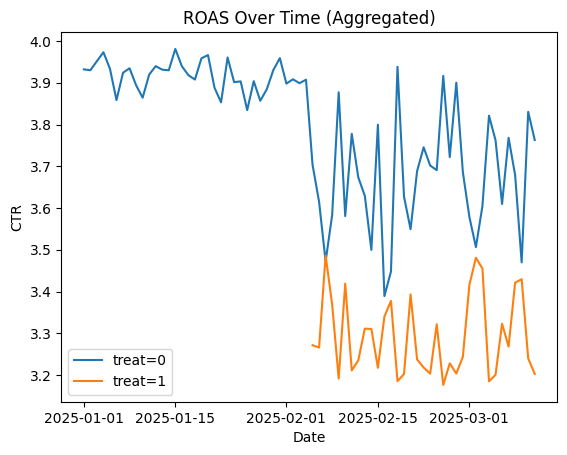

In [ ]:
#@title Plot ROAS + CTR Over Time
plt.figure()
for treat, sub in daily.groupby("treat"):
  plt.plot(sub["date"], sub["roas"], label=f"treat={treat}")
plt.title("ROAS Over Time (Aggregated)")
plt.xlabel("Date")
plt.ylabel("CTR")
plt.legend()
plt.show()

In [ ]:
#@title Post-period decomposition (drivers + guardrails)
post_df = df_clean[df_clean["post"] == 1].copy()

summary = post_df.groupby("treat").agg(
    ctr=("ctr", "mean"),
    cvr=("cvr", "mean"),
    cpc=("cpc", "mean"),
    roas=("roas", "mean"),
    bounce=("bounce_rate_proxy", "mean"),
    spend=("spend", "mean"),
).reset_index()

summary

,treat,ctr,cvr,cpc,roas,bounce,spend
0,0,0.014747,0.093909,1.158857,3.033431,0.309175,116.012107
1,1,0.018046,0.101229,1.486591,2.782908,0.336677,196.091031


# Segment slice-and-dice (geo)

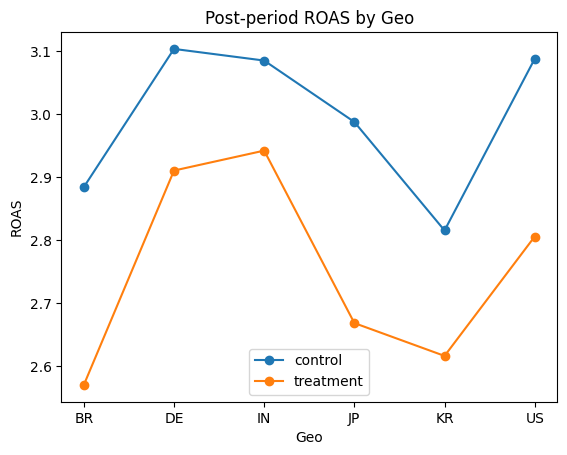

,geo,treat,roas,ctr,cvr,cpc,bounce,n
0,BR,0,2.884304,0.013491,0.089203,1.112798,0.311997,1387
1,BR,1,2.570782,0.016598,0.093678,1.431203,0.341386,1340
2,DE,0,3.103265,0.014847,0.094968,1.173353,0.309232,1383
3,DE,1,2.910501,0.018226,0.101996,1.504436,0.335377,1486
4,IN,0,3.084818,0.014542,0.093788,1.174596,0.308158,1602
5,IN,1,2.942109,0.018044,0.104782,1.526794,0.335192,1723
6,JP,0,2.987488,0.014953,0.092179,1.126987,0.311684,1153
7,JP,1,2.668791,0.018492,0.097655,1.460699,0.337699,1190
8,KR,0,2.815559,0.016129,0.096204,1.185954,0.307141,948
9,KR,1,2.616757,0.019284,0.103328,1.496805,0.335794,1082


In [ ]:
#@title ROAS by geo (post period)
seg = post_df.groupby(["geo", "treat"]).agg(
    roas=("roas", "mean"),
    ctr=("ctr", "mean"),
    cvr=("cvr", "mean"),
    cpc=("cpc", "mean"),
    bounce=("bounce_rate_proxy", "mean"),
    n=("campaign_id", "count")
).reset_index()

pivot = seg.pivot(index="geo", columns="treat", values="roas")
plt.figure()
plt.plot(pivot.index.astype(str), pivot[0], marker="o", label="control")
plt.plot(pivot.index.astype(str), pivot[1], marker="o", label="treatment")
plt.title("Post-period ROAS by Geo")
plt.xlabel("Geo")
plt.ylabel("ROAS")
plt.legend()
plt.show()

seg.sort_values(["geo", "treat"]).head(12)


#4) A/B test style readout (even if rollout is messy)
####We compute:

#####SRM-like check (only if you expected a specific split)
#####CTR lift + p-value (two-proportion z-test)
#####ROAS lift (bootstrap CI)
#####guardrail deltas
#####segmented uplift (device cohorts)
Then we ask: is it causal? (likely not fully, due to selection bias)

In [ ]:
#@title Assignment Distribution(post period)
assign = post_df["treat"].value_counts(normalize=True).rename("share").reset_index().rename(columns={"index": "treat"})
assign

,treat,share
0,1,0.519111
1,0,0.480889


##SRM sanity check (if experiment expected 50/50)

#####If your design expects 50/50 and the observed split is off, you may have an assignment bug or filtering bug. If the rollout is intentionally uneven, don’t force an SRM test, but you still monitor stability by day.

In [ ]:
#@title SRM check(only valid if 50/50 expected)
obs = post_df["treat"].value_counts().sort_index().values
exp = np.array([0.5, 0.5]) * obs.sum()

chi2, p_srm = chisquare(f_obs=obs, f_exp=exp)
print("Observed counts [control, treatment]:", obs)
print("Expected counts [control, treatment]:", exp.astype(int))
print("SRM p-value:", float(p_srm))


Observed counts [control, treatment]: [11776 12712]
Expected counts [control, treatment]: [12244 12244]
SRM p-value: 2.212962679427662e-09


In [ ]:
#@title CTR Lift: Two proportion Z test

agg = post_df.groupby("treat").agg(clicks=("clicks", "sum"), impr=("impressions", "sum")).reset_index()
agg["ctr"] = agg["clicks"]/agg["impr"]

clicks_t = int(agg.loc[agg["treat"]==1, "clicks"])
clicks_c = int(agg.loc[agg["treat"]==0, "clicks"])
impr_t = int(agg.loc[agg["treat"]==1, "impr"])
impr_c = int(agg.loc[agg["treat"]==0, "impr"])

z, p = proportions_ztest([clicks_t, clicks_c], [impr_t, impr_c])
delta_ctr = (clicks_t/impr_t) - (clicks_c/impr_c)
rel_lift_ctr = delta_ctr / (clicks_c/impr_c)

print("CTR control:", clicks_c/impr_c)
print("CTR treatment:", clicks_t/impr_t)
print("Absolute delta:", delta_ctr)
print("Relative lift:", rel_lift_ctr)
print("p-value:", float(p))



CTR control: 0.015403154378619121
CTR treatment: 0.018768652249313064
Absolute delta: 0.0033654978706939426
Relative lift: 0.21849406868021382
p-value: 0.0


/tmp/ipython-input-608530448.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  clicks_t = int(agg.loc[agg["treat"]==1, "clicks"])
/tmp/ipython-input-608530448.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  clicks_c = int(agg.loc[agg["treat"]==0, "clicks"])
/tmp/ipython-input-608530448.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  impr_t = int(agg.loc[agg["treat"]==1, "impr"])
/tmp/ipython-input-608530448.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  impr_c = int(agg.loc[agg["treat"]==0, "impr"])


In [ ]:
#@title Roas Lift: Bootstrap CI (Roas is heavily tailed)
def bootstrap_mean_diff(x_t, x_c, n_boot=2000):
    x_t = np.array(x_t)
    x_c = np.array(x_c)
    diffs = []

    for _ in range(n_boot):
        bt = np.random.choice(x_t, size=len(x_t), replace=True).mean()
        bc = np.random.choice(x_c, size=len(x_c), replace=True).mean()
        diffs.append(bt - bc)

    # FIXED: Convert to numpy array to use .mean() or use np.mean(diffs)
    # FIXED: Moved outside the for loop
    diffs = np.array(diffs)
    return diffs.mean(), np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)

# --- Execution ---
roas_t = post_df.loc[post_df["treat"]==1, "roas"].dropna()
roas_c = post_df.loc[post_df["treat"]==0, "roas"].dropna()

roas_diff_mean, roas_ci_low, roas_ci_high = bootstrap_mean_diff(roas_t, roas_c)

print("Roas mean diff (treatment-control):", float(roas_diff_mean))
print("95% CI:", (float(roas_ci_low), float(roas_ci_high)))

# --- Guardrail Metrics ---
guard = post_df.groupby("treat").agg(
    cpc=("cpc", "mean"),
    bounce=("bounce_rate_proxy", "mean"),
    cvr=("cvr", "mean"),
).reset_index()

guard


Roas mean diff (treatment-control): -0.2501958041590059
95% CI: (-0.29488265403855135, -0.20425779481164447)


,treat,cpc,bounce,cvr
0,0,1.158857,0.309175,0.093909
1,1,1.486591,0.336677,0.101229


# Segmented Uplifts

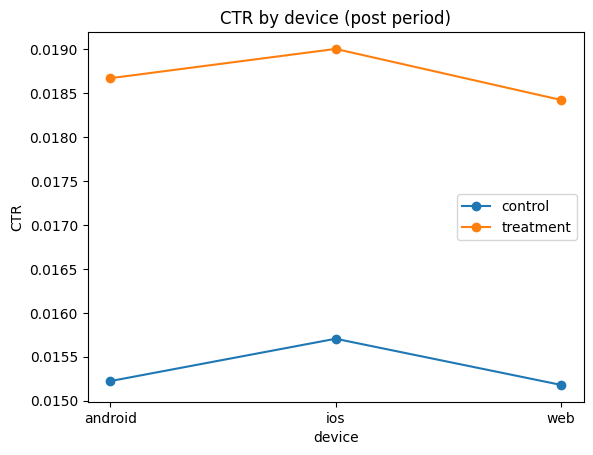

,device,treat,clicks,impr,roas,cpc,bounce,ctr
0,android,0,496706,32628122,3.135149,1.085187,0.309694,0.015223
1,android,1,714711,38286544,2.866869,1.415889,0.337123,0.018667
2,ios,0,420904,26800534,2.803753,1.255357,0.309741,0.015705
3,ios,1,637465,33550084,2.632385,1.582524,0.336646,0.019000
4,web,0,151057,9951094,3.334636,1.131964,0.305958,0.015180
5,web,1,205994,11183185,2.934200,1.442737,0.335397,0.018420


In [ ]:
#@title CTR by device (post period)

device_seg = post_df.groupby(["device", "treat"]).agg(
    clicks=("clicks", "sum"),
    impr=("impressions", "sum"),
    roas=("roas", "mean"),
    cpc=("cpc", "mean"),
    bounce=("bounce_rate_proxy", "mean"),
).reset_index()
device_seg["ctr"] = device_seg["clicks"]/device_seg["impr"]

ctr_pivot = device_seg.pivot(index="device", columns="treat", values="ctr")
plt.figure()
plt.plot(ctr_pivot.index.astype(str), ctr_pivot[0], marker="o", label="control")
plt.plot(ctr_pivot.index.astype(str), ctr_pivot[1], marker="o", label="treatment")
plt.title("CTR by device (post period)")
plt.xlabel("device")
plt.ylabel("CTR")
plt.legend()
plt.show()

device_seg.sort_values(["device","treat"])


#4.5) Experiment planning: power analysis, MDE, decision rules
###Even if today’s rollout is messy, you’ll propose a cleaner follow-up experiment:

#####define what “material” means (MDE)
#####compute sample size needed
#####set a decision rule (ship/iterate/rollback)

####This is a common case study differentiator.

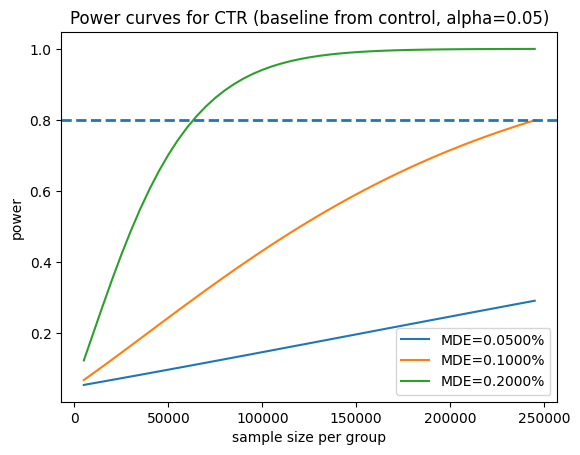

Baseline CTR: 0.015403154378619121
MDE absolute: 0.001
Required n per group for 80% power: 245613.07679816886

Decision rule example:
- Ship if: ROAS CI > 0 and guardrails OK (CPC, bounce within thresholds)
- Iterate if: CI crosses 0 but direction stable and risk reversible
- Roll back if: ROAS drops beyond threshold or guardrails break materially


In [ ]:
#@title Power / MDE for CTR (baseline from control)
analysis = NormalIndPower()
alpha = 0.05
target_power = 0.80

ctr0 = clicks_c / impr_c
mde_abs_list = [0.0005, 0.0010, 0.0020]
n_grid = np.arange(5000, 250000, 5000)

plt.figure()
for mde_abs in mde_abs_list:
    ctr1 = ctr0 + mde_abs
    effect = proportion_effectsize(ctr1, ctr0)
    power = analysis.power(effect_size=effect, nobs1=n_grid, alpha=alpha, ratio=1.0, alternative="two-sided")
    plt.plot(n_grid, power, label=f"MDE={mde_abs:.4%}")
plt.axhline(target_power, linestyle="--", linewidth=2)
plt.title("Power curves for CTR (baseline from control, alpha=0.05)")
plt.xlabel("sample size per group")
plt.ylabel("power")
plt.legend()
plt.show()

mde_abs = 0.0010  # +0.10pp
ctr1 = ctr0 + mde_abs
effect = proportion_effectsize(ctr1, ctr0)
n_required = analysis.solve_power(effect_size=effect, power=target_power, alpha=alpha, ratio=1.0, alternative="two-sided")

print("Baseline CTR:", float(ctr0))
print("MDE absolute:", float(mde_abs))
print("Required n per group for 80% power:", float(n_required))

print("\nDecision rule example:")
print("- Ship if: ROAS CI > 0 and guardrails OK (CPC, bounce within thresholds)")
print("- Iterate if: CI crosses 0 but direction stable and risk reversible")
print("- Roll back if: ROAS drops beyond threshold or guardrails break materially")

# 5) Reality Check: Selection Bias:

#### Treatment was prioritized to higher quality campaigns. Naive treatment vs comtrol comparisons are not nully casual

#### We prove it by comparing pre period uality/performance between cohorts


In [ ]:
#@title pre-perios cohort bias check
pre_df = df_clean[df_clean["post"]==0].copy()

treated_campaigns = set(df_clean.loc[df_clean["treat"]==1, "campaign_id"].unique())
pre_df["cohort_treat_flag"] = pre_df["campaign_id"].isin(treated_campaigns).astype(int)

pre_summary = pre_df.groupby("cohort_treat_flag").agg(
    quality=("quality","mean"),
    roas=("roas","mean"),
    ctr=("ctr","mean"),
    cvr=("cvr","mean"),
    cpc=("cpc","mean"),
    n_campaigns=("campaign_id","nunique")
).reset_index()

pre_summary

,cohort_treat_flag,quality,roas,ctr,cvr,cpc,n_campaigns
0,1,0.394629,3.286482,0.015412,0.103664,1.235639,700
